In [1]:
import hopsworks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import numpy as np
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
import os

In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login(api_key_value='mvAJH9queUocj5wN.skwtHCxoMiGJdqUgfq2r2SbJZMEdy9x3NZ8PN4kEmvwhE3nT5aIwRSDuRPEIIYea')
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/191638
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
weather_fg = fs.get_feature_group(name="weather", version=1)
#query = weather_fg.select_all()
"""
feature_view = fs.get_or_create_feature_view(name="weather",
                                  version=1,
                                  description="",
                                  labels=['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'surface_pressure', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m', 'day_cos', 'day_sin', 'hour_cos', 'hour_sin'],
                                  query=query)
# You can read training data, randomly split into train/test sets of features (X) and labels (y)

X_train, X_test, y_train, y_test = feature_view.train_test_split(
    train_start="2023-01-01",
    train_end="2023-09-13",    
    test_start="2023-09-14", 
    test_end="2023-12-31", 
    description='Weather dataset for 2023'
)
"""

'\nfeature_view = fs.get_or_create_feature_view(name="weather",\n                                  version=1,\n                                  description="",\n                                  labels=[\'temperature_2m\', \'apparent_temperature\', \'rain\', \'snowfall\', \'surface_pressure\', \'cloud_cover\', \'wind_speed_10m\', \'wind_direction_10m\', \'day_cos\', \'day_sin\', \'hour_cos\', \'hour_sin\'],\n                                  query=query)\n# You can read training data, randomly split into train/test sets of features (X) and labels (y)\n\nX_train, X_test, y_train, y_test = feature_view.train_test_split(\n    train_start="2023-01-01",\n    train_end="2023-09-13",    \n    test_start="2023-09-14", \n    test_end="2023-12-31", \n    description=\'Weather dataset for 2023\'\n)\n'

In [4]:
X_data = weather_fg.read()
# Use less data for testing
raw_X_data = X_data.sort_values(by='index').drop(columns=['index'])[-40000:]
print(X_data)

Finished: Reading data from Hopsworks, using ArrowFlight (3.33s) from Hopsworks, using ArrowFlight.   Reading data from Hopsworks, using ArrowFlight...   
        temperature_2m  apparent_temperature  rain  snowfall  \
0             1.765000             -1.258948   0.0      0.00   
1             4.065000             -1.359238   0.0      0.00   
2             5.365000              2.232991   0.0      0.00   
3             3.915000              0.977400   0.0      0.00   
4            22.215000             23.202057   0.0      0.00   
...                ...                   ...   ...       ...   
210235       19.365000             18.992956   0.0      0.00   
210236        4.015000              1.014155   0.0      0.00   
210237       12.315000             10.890267   0.0      0.00   
210238        9.264999              5.687208   0.0      0.00   
210239       -0.785000             -4.932779   0.0      0.07   

        surface_pressure  cloud_cover  wind_speed_10m  wind_direction_10m  \

In [5]:
# Drop the first and last row from the target and training data respectively.
Y_data = raw_X_data[1:].copy()
Y_data = Y_data.drop(columns=['day_cos', 'day_sin', 'hour_cos', 'hour_sin']).to_numpy()
X_data = raw_X_data[:-1].copy().to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(X_data.copy(), Y_data.copy(), test_size=0.2, random_state=42, shuffle=True)

In [6]:
# Normalize to zero mean and unit variance for faster convergence!
scaler = StandardScaler()
scaler.fit(X_train[:, :8])

# Do not scale the day/hour encoding
X_train[:, :8] = scaler.transform(X_train[:, :8])
X_test[:, :8] = scaler.transform(X_test[:, :8])

Y_train = scaler.transform(Y_train)
Y_test = scaler.transform(Y_test)

In [7]:
print(Y_train)
print(X_train)
print(scaler.mean_)
print(scaler.var_)

[[ 2.5280995   2.2746816  -0.21742679 ... -0.8979801   0.07251871
  -0.13084865]
 [-0.77202517 -0.7146839  -0.21742679 ...  1.1506445  -0.7101056
  -0.27787128]
 [ 0.92822903  0.8916201  -0.21742679 ... -1.4623971   0.16497844
  -1.5003967 ]
 ...
 [-0.9727933  -0.80109113 -0.21742679 ...  1.1506445  -1.5540426
   0.9439445 ]
 [ 0.796475    0.8448194  -0.21742679 ... -0.7176802  -0.9979295
  -1.6900043 ]
 [-0.9476972  -0.7831539  -0.21742679 ...  0.7482363  -1.5956451
  -0.17368816]]
[[ 2.66612751  2.39405991 -0.21742679 ... -0.23030567 -0.5
  -0.8660254 ]
 [-0.84731322 -0.76909363 -0.21742679 ...  0.96112978  0.5
  -0.8660254 ]
 [ 0.94077709  0.94914955 -0.21742679 ...  0.17976659  0.96592583
  -0.25881905]
 ...
 [-0.92887524 -0.7739946  -0.21742679 ...  0.32126966  0.70710678
   0.70710678]
 [ 0.71491302  0.79208517 -0.21742679 ... -0.99925001 -0.8660254
   0.5       ]
 [-0.87868323 -0.71160248 -0.21742679 ... -0.52341561 -0.96592583
  -0.25881905]]
[7.41757472e+00 4.39083278e+00 5.71

In [8]:
n_input = 12 # Number of features
n_hidden = 512  # Number of hidden nodes
n_out = 8 # Number of classes

class WeatherModel(nn.Module):
    def __init__(self):
        super(WeatherModel, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.bn1 = nn.BatchNorm1d(n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.bn2 = nn.BatchNorm1d(n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.bn3 = nn.BatchNorm1d(n_hidden)
        self.fc4 = nn.Linear(n_hidden, n_hidden)
        self.bn4 = nn.BatchNorm1d(n_hidden)
        self.fc5 = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, n_out)

    def forward(self, x):
        silu = nn.SiLU()
        x = silu(self.bn1(self.fc1(x)))
        x = silu(self.bn2(self.fc2(x)))
        x = silu(self.bn3(self.fc3(x)))
        x = silu(self.bn4(self.fc4(x)))
        x = self.out(self.fc5(x))
        return x

model = WeatherModel()

# Hyper-parameters
epochs = 50
batch_size = 512
learning_rate = 0.001

# Define loss function, optimizer, and convert data to tensors
loss_fun = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
x_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(Y_train, dtype=torch.float32)
x_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(Y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

# Define dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

train_loss_array = []
val_loss_array = []

# Training loop
epoch_loop = tqdm(range(epochs), desc=f"Epoch {1}/{epochs}")
for epoch in epoch_loop:
    train_loss = 0
    val_loss = 0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_fun(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation loop with tqdm
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            val_loss += loss_fun(outputs, batch_y).item()
        val_loss /= len(test_loader)
        epoch_loop.set_description(f"Epoch {epoch + 1}/{epochs} [Train Loss: {train_loss:.4f}] [Validation Loss: {val_loss:.4f}]")

        train_loss_array.append(train_loss)
        val_loss_array.append(val_loss)


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

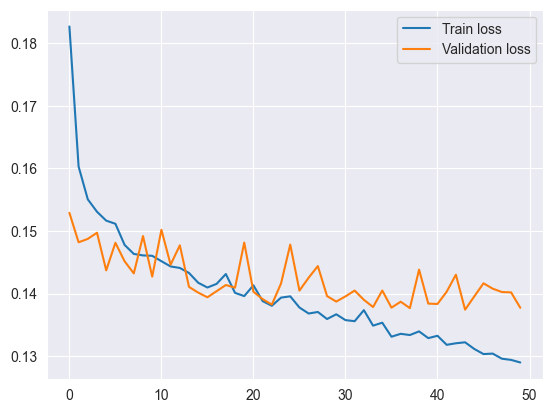

In [9]:
plt.plot(range(len(train_loss_array)), train_loss_array, label='Train loss')
plt.plot(range(len(val_loss_array)), val_loss_array, label='Validation loss')
plt.legend()
plt.show()

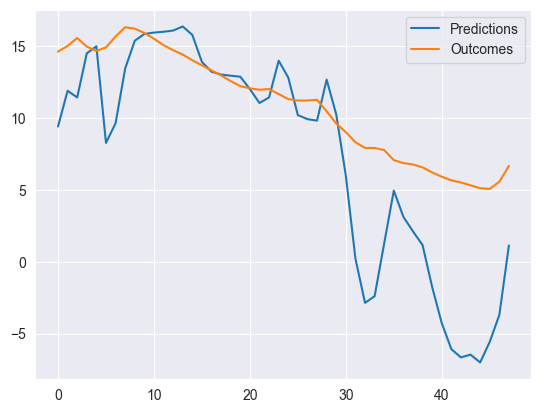

In [22]:
# Try to plot features over 2 days amd compare to true values
test_data = raw_X_data.to_numpy().copy()[50000:50000 + 49]
test_data[:, :8] = scaler.transform(test_data[:, 0:8])

predictions = model(torch.tensor(test_data[:48], dtype=torch.float32))
predictions = scaler.inverse_transform(predictions.detach().numpy())
plt.plot(range(48), predictions[:, 0], label='Predictions')
plt.plot(range(48), raw_X_data.to_numpy()[50001:50000 + 49, 0], label='Outcomes')
plt.legend()
plt.show()

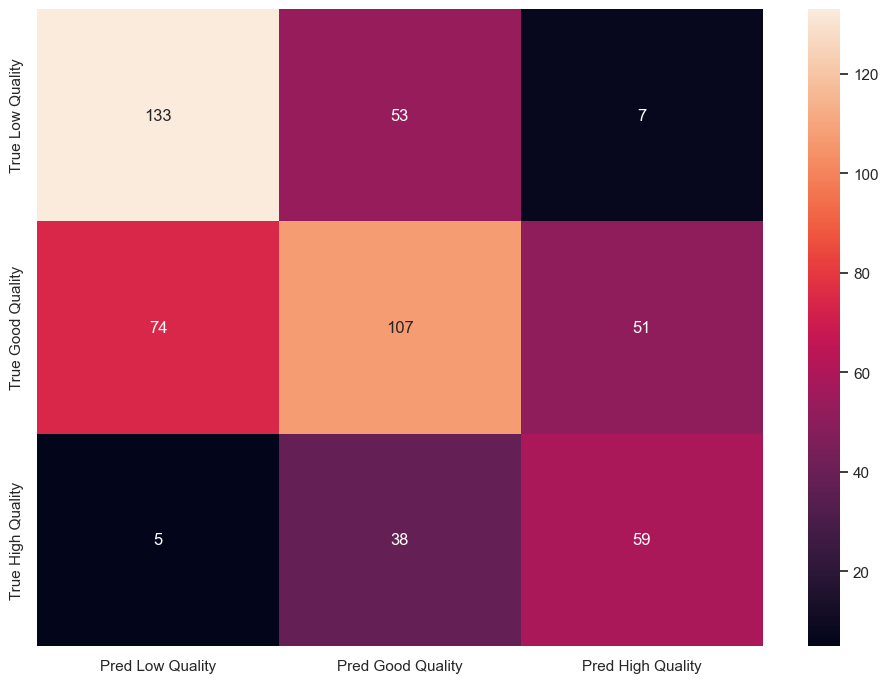

In [23]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="weather_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
model.save_weights(model_dir + '/weather_model.h5')
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
weather_model = mr.python.create_model(
    name="weather_model",
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Weather predictor for Stockholm"
)

# Upload the model to the model registry, including all files in 'model_dir'
weather_model.save(model_dir)